# 1. Import

**1.1 Import kagglehub and download dataset**

In [1]:
!pip install kagglehub
from google.colab import files

import kagglehub

# Download the latest version of the dataset
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")

print("Path to dataset files:", path)

100%|██████████| 2.70G/2.70G [02:02<00:00, 23.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2


**1.2 Define the paths**

In [2]:
import os

# Define the dataset path
root_folder = "/root/.cache/kagglehub/datasets/vipoooool/new-plant-diseases-dataset/versions/2"

data_dir = os.path.join(root_folder, 'new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/')

test_path = os.path.join(root_folder, 'test/test')
train_path = os.path.join(data_dir, 'train')
valid_path = os.path.join(data_dir, 'valid')

# Count the number of folders in a directory
def count_folders(path):
    if os.path.exists(path):
        return len([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])
    else:
        print(f"Path does not exist: {path}")
        return 0

# Count the number of files in a directory
def count_files(path):
    if os.path.exists(path):
        return len([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))])
    else:
        print(f"Path does not exist: {path}")
        return 0

# Function to count files in each folder of a given directory
def count_files_in_folders(path):
    if not os.path.exists(path):
        print(f"Path does not exist: {path}")
        return {}

    folder_file_counts = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            file_count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
            folder_file_counts[folder] = file_count

    return folder_file_counts

# Print counts
print(f"Number of folders in train_path: {count_folders(train_path)}")
print(f"Number of folders in valid_path: {count_folders(valid_path)}")
print(f"Number of files in test_path: {count_files(test_path)}")
print('-------------------------------------------------------------------')
# Count files in each folder
train_folder_counts = count_files_in_folders(train_path)
valid_folder_counts = count_files_in_folders(valid_path)
# Display results
print("Files in each folder (train_path):")
for folder, count in train_folder_counts.items():
    print(f"{folder}: {count} files")

print("\nFiles in each folder (valid_path):")
for folder, count in valid_folder_counts.items():
    print(f"{folder}: {count} files")

Number of folders in train_path: 38
Number of folders in valid_path: 38
Number of files in test_path: 33
-------------------------------------------------------------------
Files in each folder (train_path):
Tomato___healthy: 1926 files
Strawberry___Leaf_scorch: 1774 files
Tomato___Target_Spot: 1827 files
Corn_(maize)___Northern_Leaf_Blight: 1908 files
Peach___healthy: 1728 files
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1722 files
Potato___healthy: 1824 files
Apple___Black_rot: 1987 files
Tomato___Bacterial_spot: 1702 files
Tomato___Late_blight: 1851 files
Grape___healthy: 1692 files
Tomato___Tomato_Yellow_Leaf_Curl_Virus: 1961 files
Tomato___Leaf_Mold: 1882 files
Cherry_(including_sour)___healthy: 1826 files
Apple___Cedar_apple_rust: 1760 files
Tomato___Tomato_mosaic_virus: 1790 files
Grape___Black_rot: 1888 files
Peach___Bacterial_spot: 1838 files
Tomato___Spider_mites Two-spotted_spider_mite: 1741 files
Corn_(maize)___Common_rust_: 1907 files
Raspberry___healthy: 1781 files
Potat

**1.3 Importing necessary libraries for data processing and visualization**

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import glob

**1.4 Creating a DataFrame with Train and Valid**

In [4]:
# Initialize lists
image_paths = []
species_labels = []
disease_labels = []
dataset_split = []

# Function to process a dataset directory
def process_directory(base_path, split_name):
    for class_folder in os.listdir(base_path):
        class_folder_path = os.path.join(base_path, class_folder)
        if os.path.isdir(class_folder_path):
            species, disease = class_folder.split('___')
            for image_name in os.listdir(class_folder_path):
                image_paths.append(os.path.join(class_folder_path, image_name))
                species_labels.append(species)
                disease_labels.append(disease)
                dataset_split.append(split_name)

# Process train and valid
process_directory(train_path, 'train')
process_directory(valid_path, 'valid')

# Create DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'species': species_labels,
    'disease': disease_labels,
    'split': dataset_split
})

# Display first few rows
print(df.head())


                                          image_path species  disease  split
0  /root/.cache/kagglehub/datasets/vipoooool/new-...  Tomato  healthy  train
1  /root/.cache/kagglehub/datasets/vipoooool/new-...  Tomato  healthy  train
2  /root/.cache/kagglehub/datasets/vipoooool/new-...  Tomato  healthy  train
3  /root/.cache/kagglehub/datasets/vipoooool/new-...  Tomato  healthy  train
4  /root/.cache/kagglehub/datasets/vipoooool/new-...  Tomato  healthy  train


# 2. Data segmentation

2.1 Separated sets for train and valid


In [8]:
df_train = df[df['split'] == 'train']
df_valid = df[df['split'] == 'valid']
df_train.head()

,image_path,species,disease,split
0,/root/.cache/kagglehub/datasets/vipoooool/new-...,Tomato,healthy,train
1,/root/.cache/kagglehub/datasets/vipoooool/new-...,Tomato,healthy,train
2,/root/.cache/kagglehub/datasets/vipoooool/new-...,Tomato,healthy,train
3,/root/.cache/kagglehub/datasets/vipoooool/new-...,Tomato,healthy,train
4,/root/.cache/kagglehub/datasets/vipoooool/new-...,Tomato,healthy,train


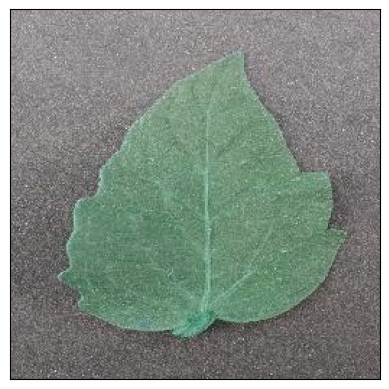

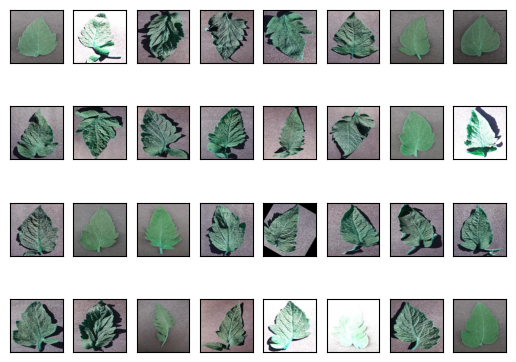

In [16]:
import cv2

# Select images for transformation
train_paths = df_train['image_path'].tolist()
valid_paths = df_valid['image_path'].tolist()


# Show image examples
train_paths[:5]
img_color = cv2.imread(train_paths[1], cv2.IMREAD_COLOR)
plt.imshow(img_color)
plt.xticks([])
plt.yticks([])
plt.show();
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
  img = cv2.imread(train_paths[i], cv2.IMREAD_COLOR)
  axi.imshow(img)

2.2 Data segmentation

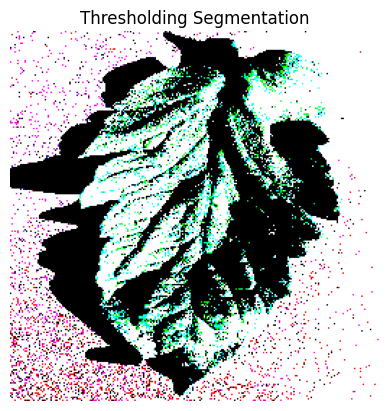

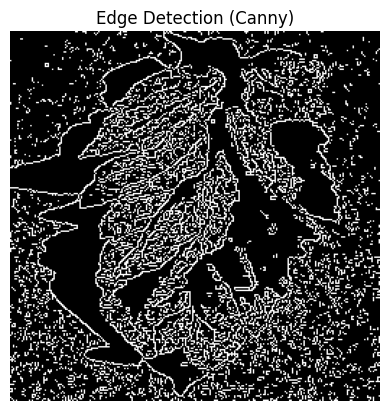

In [32]:
import cv2

# Apply a simple thresholding
image = cv2.imread(train_paths[2], cv2.IMREAD_COLOR)
_, segmented_image = cv2.threshold(image, 90, 255, cv2.THRESH_BINARY)

# Display the segmented image
plt.imshow(segmented_image, cmap='gray')
plt.title("Thresholding Segmentation")
plt.axis('off')
plt.show()

# Apply Canny edge detection
edges = cv2.Canny(image, 250, 200)

# Display the edge-detected image
plt.imshow(edges, cmap='gray')
plt.title("Edge Detection (Canny)")
plt.axis('off')
plt.show()

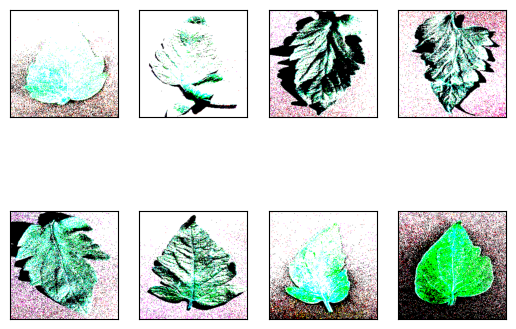

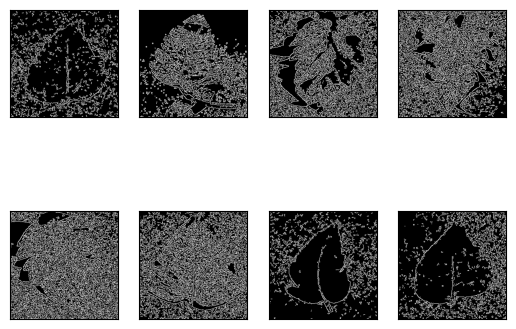

In [33]:
# Apply thresohlding for multiple images and show
fig, ax = plt.subplots(2, 4, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
  img = cv2.imread(train_paths[i], cv2.IMREAD_COLOR)
  _, segmented_image = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  axi.imshow(segmented_image)

# Apply Canny edge detection fro multiple images and show
fig, ax = plt.subplots(2, 4, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
  img = cv2.imread(train_paths[i], cv2.IMREAD_COLOR)
  edges = cv2.Canny(img, 100, 200)
  axi.imshow(edges, cmap='gray')

2.3 Get the full data segmented (too resource consuming)

In [ ]:
segmented_train_data = []
for i in range(len(train_paths)):
  img = cv2.imread(train_paths[i], cv2.IMREAD_COLOR)
  _, segmented_image = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  segmented_train_data.append(segmented_image)

In [ ]:
import cv2
import numpy as np

train_paths = df_train['image_path'].tolist()
valid_paths = df_valid['image_path'].tolist()


batch_size = 32  # Set a reasonable batch size to manage memory usage
segmented_train_data = []

# Process images in batches
for batch_start in range(0, len(train_paths), batch_size):
    # Determine the current batch (end index is the minimum of batch_start + batch_size or len(train_paths))
    batch_end = min(batch_start + batch_size, len(train_paths))

    # Process each image in the current batch
    for i in range(batch_start, batch_end):
        img = cv2.imread(train_paths[i], cv2.IMREAD_COLOR)

        if img is None:
            continue  # Skip if the image couldn't be loaded

        # Apply thresholding to the image
        _, segmented_image = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)

        # Append the segmented image to the list
        segmented_train_data.append(segmented_image)

    # Optionally, free up memory after processing each batch
    del img
    del segmented_image
    import gc
    gc.collect()  # Garbage collection to free up memory

# After this, segmented_train_data will contain all the thresholded images.